# Exercício 1

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [106]:
ds = pd.read_csv('crx.data', header=None)

print(ds)

    0      1       2  3  4   5   6     7  8  9   10 11 12     13   14 15
0    b  30.83   0.000  u  g   w   v  1.25  t  t   1  f  g  00202    0  +
1    a  58.67   4.460  u  g   q   h  3.04  t  t   6  f  g  00043  560  +
2    a  24.50   0.500  u  g   q   h  1.50  t  f   0  f  g  00280  824  +
3    b  27.83   1.540  u  g   w   v  3.75  t  t   5  t  g  00100    3  +
4    b  20.17   5.625  u  g   w   v  1.71  t  f   0  f  s  00120    0  +
..  ..    ...     ... .. ..  ..  ..   ... .. ..  .. .. ..    ...  ... ..
685  b  21.08  10.085  y  p   e   h  1.25  f  f   0  f  g  00260    0  -
686  a  22.67   0.750  u  g   c   v  2.00  f  t   2  t  g  00200  394  -
687  a  25.25  13.500  y  p  ff  ff  2.00  f  t   1  t  g  00200    1  -
688  b  17.92   0.205  u  g  aa   v  0.04  f  f   0  f  g  00280  750  -
689  b  35.00   3.375  u  g   c   h  8.29  f  f   0  t  g  00000    0  -

[690 rows x 16 columns]


# Exercício 2

In [352]:
def equal_width(n_bin,col):
    bins_bound=[]
    bins= []
    width= int((max(col) - min(col))/n_bin)
    l_bound = int(min(col))
    for i in range(n_bin):
        bins_bound.append([l_bound, l_bound+width])
        l_bound = l_bound+width+1
    
    for i in range(len(bins_bound)):
        bin=[]
        for j in range(len(col)):            
            if bins_bound[i][0]<j<bins_bound[i][1]:
                bin.append(j)
        bins.append(bin)
    return bins,bins_bound

def equal_height(freq,col):
    equal_width_bin = []
    j = 0
    for i in range(freq):
        bin = []
        while len(bin) != len(col) / freq:
            bin.append(col[j])
            j+=1
        equal_width_bin.append(bin)
    return equal_width_bin

def missing_val(col):
    idx_unk=[]
    acc = 0
    total = 0
    for i in range(len(col)):
        try:
            col[i] = float(col[i])
            acc += col[i]
            total += 1
        except ValueError as e:
            #print('Missing record on line', i,'- Replacing by average')
            idx_unk.append(i)
    if len(idx_unk) > 0:
        print('Missing record on lines', idx_unk,'- Replacing by average')
    else:
        print('No missing records')
    avg = round(acc/total,2)
    for i in idx_unk:
        col[i] = avg
    return col

In [353]:
data_col = ds[1].tolist()

data_col = missing_val(data_col)

Missing record on lines [83, 86, 92, 97, 254, 286, 329, 445, 450, 500, 515, 608] - Replacing by average


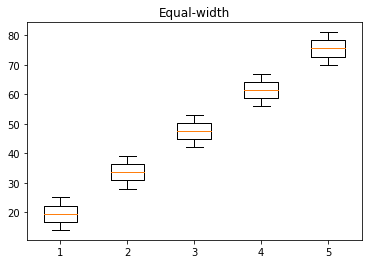

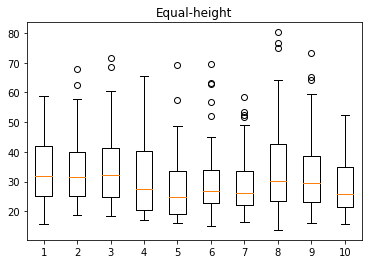

690


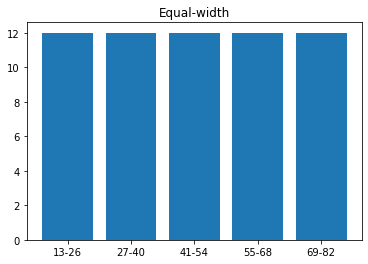

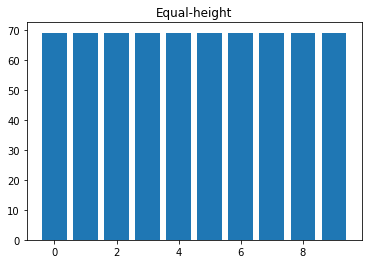

In [387]:
plt.boxplot(equal_width(5,data_col)[0])
plt.title('Equal-width')
plt.show()
plt.boxplot(equal_height(10,data_col))
plt.title('Equal-height')
plt.show()

# Conversao para bar---------------------
e_w = equal_width(5,data_col)
e_h = equal_height(10,data_col)

for i in range(len(e_h)):
    e_h[i] = len(e_h[i])
    
label = []
for i in range(len(e_w[1])):
    s='' + str(e_w[1][i][0]) + '-'+str(e_w[1][i][1])
    
    label.append(s)
for i in range(len(e_w[0])):
    e_w[0][i] = len(e_w[0][i])
#---------------------------------------

plt.bar(label,e_w[0])
plt.title('Equal-width')
plt.show()
plt.bar([i for i in range(10)],e_h)
plt.title('Equal-height')
plt.show()

# Exercício 3

## KNN

In [330]:
def euclidean_distance(row1, row2):
    distance = 0
    for i in range(len(row1)-1):
        #print(row1[i],row2[i])
        distance = distance + math.pow(row1[i] - row2[i], 2)
    return math.sqrt(distance)


def get_n_neighbors(t_inputs, test_input, k):
    distances = []
    for i in range(len(t_inputs)):
        distance = euclidean_distance(test_input, t_inputs[i])
        distances.append((t_inputs[i], distance, t_inputs[i][len(t_inputs[i])-1]))
    distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for j in range(k):
        neighbors.append(distances[j][2])
    
    return neighbors


def predict(t_inputs, test_input, k):
    inputs = test_input
    neighbors = get_n_neighbors(t_inputs, inputs, k)
    output_val = [row for row in neighbors]
    prediction = max(set(output_val), key=output_val.count)
    return prediction

In [331]:
def normalization(arr,technique):
    cols = arr.T.copy()
    
    if technique == 1:
        for i in range(len(cols)-1):
            for j in range(len(cols[i])):
                cols[i][j] = (cols[i][j]-min(cols[i]))/(max(cols[i])-min(cols[i]))
    else:
        for i in range(len(cols)-1):
            mean = np.mean(cols[i])
            standard_deviation = np.std(cols[i])
            for j in range(len(cols[i])):
                cols[i][j] = (cols[i][j] - mean) / standard_deviation
   
    return cols.T

def k_fold(dataset,k,knn):
    acc_lst=[]
    fold_size = int(len(dataset)/k)
    folds=[]
    for i in range(k):
        fold = dataset[fold_size*i:fold_size*(i+1)]
        folds.append(fold)
    for i in range(len(folds)):
        test = folds[i]
        training = []
        
        for j in range(len(folds)):
            if i != j:
                for k in range(len(folds[j])):
                    training.append(folds[j][k])
        acc=0
        for j in range(len(test)):
            prediction = predict(training,test[j],knn)
            if prediction == test[j][len(test[j])-1]:
                acc += 1
        acc_lst.append(acc/len(test))
    return acc_lst
        
        

In [332]:
numerical_cols = ds.drop([0,3,4,5,6,8,9,11,12],axis = 1).to_numpy().T
for i in range(len(numerical_cols)-1):
    print('Column:',i)
    numerical_cols[i] = missing_val(numerical_cols[i])

Column: 0
Missing record on lines [83, 86, 92, 97, 254, 286, 329, 445, 450, 500, 515, 608] - Replacing by average
Column: 1
No missing records
Column: 2
No missing records
Column: 3
No missing records
Column: 4
Missing record on lines [71, 202, 206, 243, 270, 278, 330, 406, 445, 456, 592, 622, 626] - Replacing by average
Column: 5
No missing records


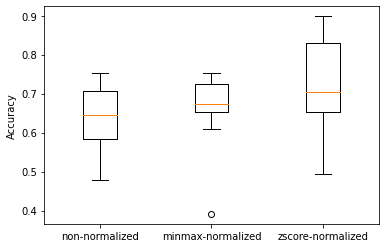

In [346]:
numerical_cols = numerical_cols.T
minmax_ds = normalization(numerical_cols,1)
zscore_ds = normalization(numerical_cols,0)

labels =['non-normalized','minmax-normalized','zscore-normalized']

plt.boxplot([k_fold(numerical_cols,10,5),k_fold(minmax_ds,10,5),k_fold(zscore_ds,10,5)])
plt.xticks([1,2,3], labels)
plt.ylabel('Accuracy')
plt.show()



O set 'minmax-normalized' foi o que produziu um conjunto de accuracy mais constante, mas o 'zscore-normalized' o que produziu a accuracy mais alta.

# Exercício 4

<p>-> Remover dados em falta ou substituí-los</p>
<p>-> Normalizar os dados</p> 
<p>-> Selecionar um subset do dataset</p>

# Exercício 5


<b>a)</b>
Tab.1

In [339]:
accuracy = (0 + 9500)/10000
precision = 0 #0/(0+0)
recall = 0/(0+500)
f1_score = 0 #2*precision*recall/(precision+recall)

print('Tab.1')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)


Tab.1
Accuracy: 0.95
Precision: 0
Recall: 0.0
F1 Score: 0


Tab.2

In [344]:
accuracy = (300 + 450)/1000
precision = 300/(300+50)
recall = 300/(300+200)
f1_score = 2*((precision*recall)/(precision+recall))

print('Tab.1')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Tab.1
Accuracy: 0.75
Precision: 0.8571428571428571
Recall: 0.6
F1 Score: 0.7058823529411764


<b>b)</b>

A tabela 1 apesar de ter uma accuracy elevada, não conseguiu classificar corretamente nenhum dos exemplos positivos.
A tabela 2 apesar de uma accuracy menor, tem valores atribuídos a precision e ao recall, com um F1 Score que dá mais confianca ao modelo. 

A qualidade do modelo da tabela 2 parece ser superior à da tabela 1.